# We determine the AUC as a function of noise level for the Kuramoto model with 10 randomly unobserved out of 100 total species:

In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import sys
import os
sys.path.append('packages/')
from utilities import *
from importlib import reload
#from utilities reload *
import utilities
import networkx as nx
import sdeint

In [2]:
plt.rcParams.update({'font.size': 16,'font.family':'arial'})

In [3]:
#Parameters:
T      = 10.
deltaT = 0.001
num_species = 100
degree = 5
num_subnw   = 90
num_bulk    = 10 #Convention: in the vector of conc. the subnetwork species appear first
parameters  = np.ones(num_species)*1
Ω           = 1.*((np.random.rand(num_species)*0.2)-0.1)

In [5]:
nw1 = nx.gnm_random_graph(num_species,num_species*degree,directed=True)

In [10]:
boundary_list = find_boundaries(nw1,np.arange(num_subnw,num_species))
print(boundary_list)

[ 2  3  5  8  9 17 25 29 32 36 39 41 43 50 51 54 61 62 63 64 66 68 70 76
 77 78 79 89]


In [11]:
len(boundary_list)

28

In [15]:
def dynamcical_system_KM(x,t):
    y    = np.zeros(nw.number_of_nodes()) + Ω #- np.mean(Ω)
    
    for i in range(len(y)):
        in_edges = [[p for p in nw.in_edges(i)][n][0] for n in range(len([m for m in nw.in_edges(i)]))]
        #print(in_edges)
        for j in in_edges:
            y[i] += c[i]*np.sin(x[j] - x[i])
            #print(j,i,c[i])
        in_edges = []
    return y

In [16]:
def wiener_KM(x,t):
    y    = η*np.ones(nw.number_of_nodes()) #+ Ω #- np.mean(Ω)
    #return np.expand_dims(y,axis=1)
    return np.diag(y)

In [17]:
nw,c,Ω,η = nw1,parameters,Ω,10**(-5)

In [19]:
num_repeats_list = np.int32(np.ceil(np.logspace(2,3,5)))
print(num_repeats_list)

[ 100  178  317  563 1000]


In [22]:
deltaT = 0.02
T = 0.2
Num_runs = num_repeats_list[-1]

In [23]:
noise_list2 = np.logspace(-3,0,10)
print(noise_list2)

[0.001      0.00215443 0.00464159 0.01       0.02154435 0.04641589
 0.1        0.21544347 0.46415888 1.        ]


In [24]:
soln2   = np.zeros([len(noise_list),int(T/deltaT)*Num_runs,num_species])
obs_noise2 = np.zeros([len(noise_list),int(T/deltaT)*Num_runs,num_species])

for n in range(len(noise_list2)):

    η = noise_list2[n]

    for i in range(Num_runs):    
        init_cond = 10*((np.random.rand(num_species)*0.2) - 0.1)

        soln_temp = (sdeint.itoEuler(f=dynamcical_system_KM,G=wiener_KM,y0=init_cond,tspan=np.arange(0,T,deltaT)))

        soln2[n,int(T/deltaT)*i:int(T/deltaT)*(i+1),:]    = soln_temp

        for j in range(num_subnw):        
            obs_noise2[n,int(T/deltaT)*i:int(T/deltaT)*(i+1),j]   = np.gradient((soln_temp[:,j]),deltaT)
    print(n)
        

0
1
2
3
4
5
6
7
8
9


(0.0, 1.0)

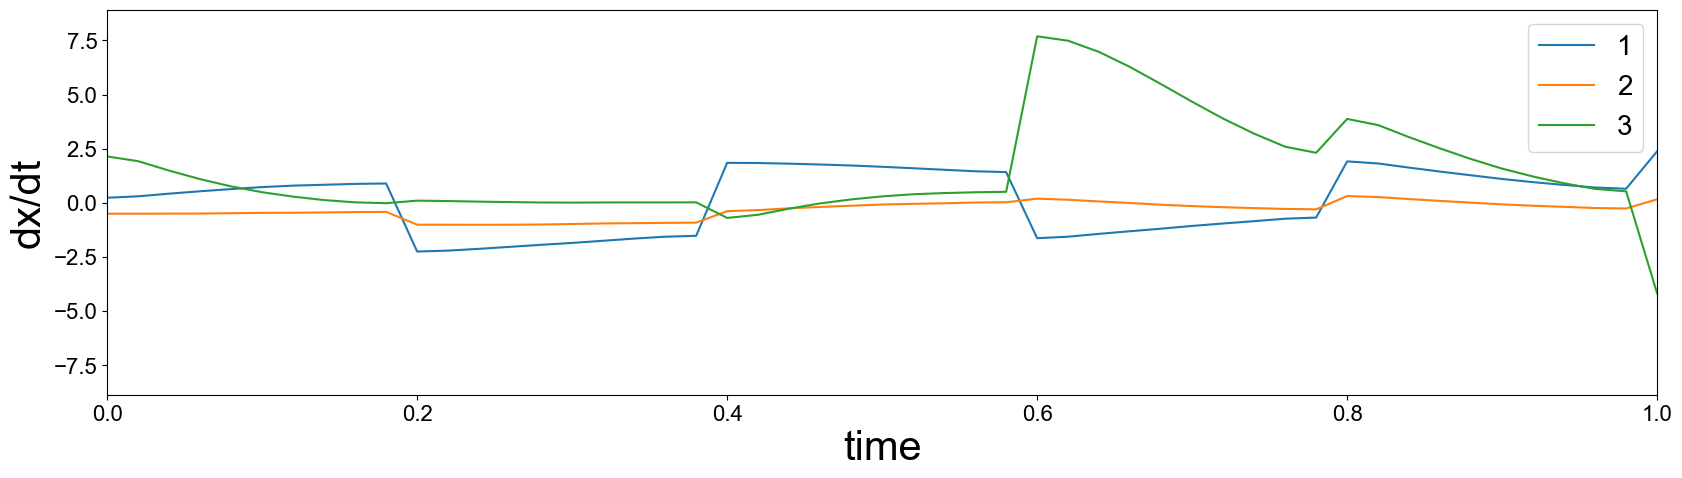

In [25]:
plt.figure(figsize=(20,5))
plt.plot(np.arange(0,Num_runs*T,deltaT),obs_noise2[0,:,0])
plt.plot(np.arange(0,Num_runs*T,deltaT),obs_noise2[0,:,1])
plt.plot(np.arange(0,Num_runs*T,deltaT),obs_noise2[0,:,2])
plt.xlabel('time',fontsize=30)
plt.ylabel('dx/dt',fontsize=30)
plt.legend(['1','2','3'],fontsize=20)
plt.xlim((0,1))

(0.0, 1.0)

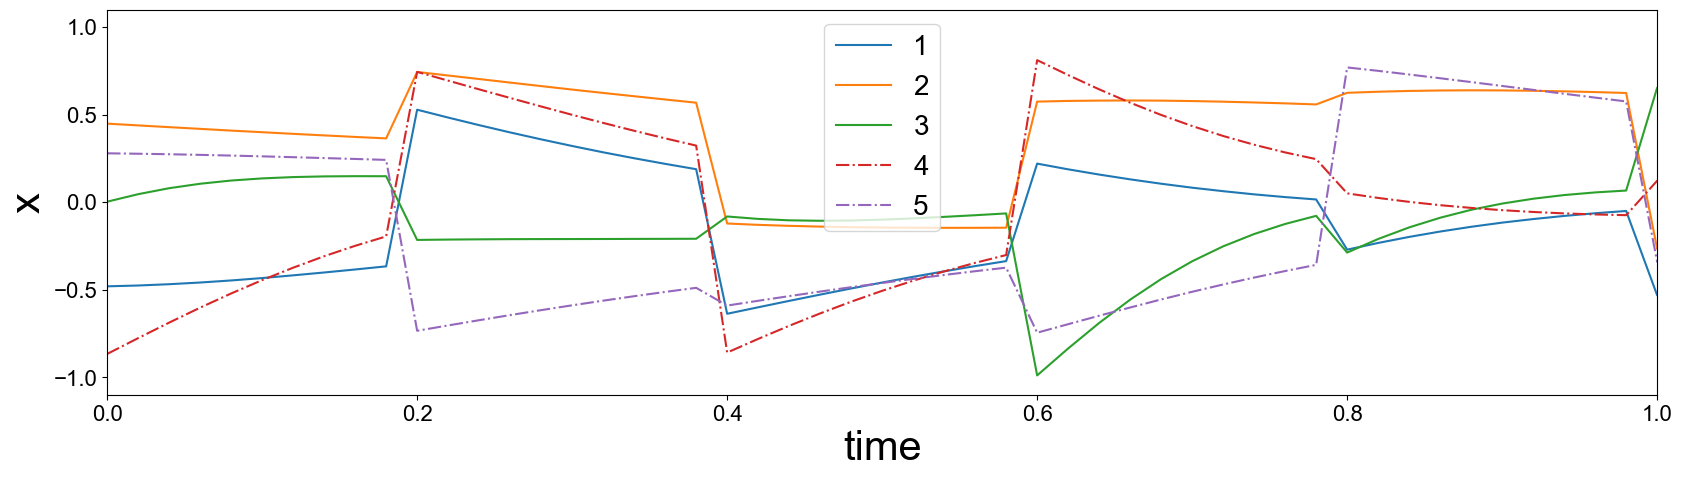

In [27]:
plt.figure(figsize=(20,5))
plt.plot(np.arange(0,Num_runs*T,deltaT),soln2[0,:,0])
plt.plot(np.arange(0,Num_runs*T,deltaT),soln2[0,:,1])
plt.plot(np.arange(0,Num_runs*T,deltaT),soln2[0,:,2])
plt.plot(np.arange(0,Num_runs*T,deltaT),soln2[0,:,3],'-.')
plt.plot(np.arange(0,Num_runs*T,deltaT),soln2[0,:,4],'-.')
plt.xlabel('time',fontsize=30)
plt.ylabel('x',fontsize=30)
plt.legend(['1','2','3','4','5'],fontsize=20)
#plt.xlim((0,5))
plt.xlim((0,1))

(0.0, 1.0)

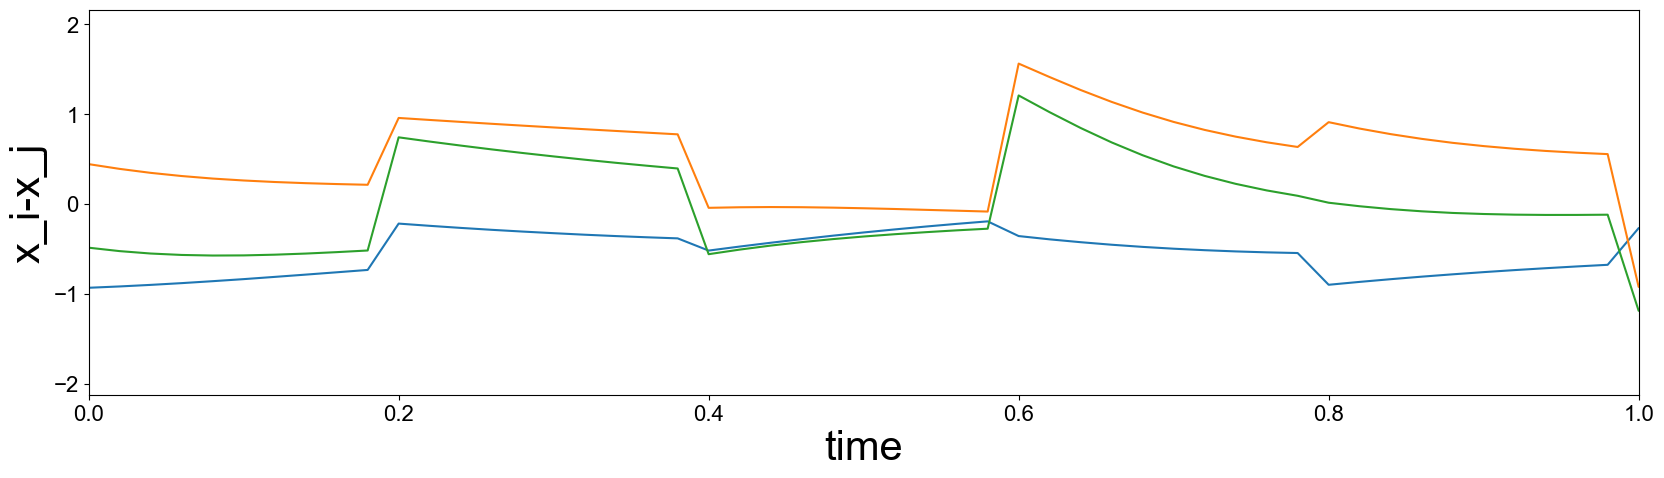

In [28]:
plt.figure(figsize=(20,5))
plt.plot(np.arange(0,Num_runs*T,deltaT),soln2[0,:,0]-soln2[0,:,1])
plt.plot(np.arange(0,Num_runs*T,deltaT),soln2[0,:,1]-soln2[0,:,2])
plt.plot(np.arange(0,Num_runs*T,deltaT),soln2[0,:,0]-soln2[0,:,2])
plt.xlabel('time',fontsize=30)
plt.ylabel('x_i-x_j',fontsize=30)
plt.xlim((0,1))

In [31]:
from sklearn import linear_model

alpha_opt3            = np.zeros((len(num_repeats_list),len(noise_list2),num_subnw))
beta_opt3             = np.zeros((len(num_repeats_list),len(noise_list2),num_subnw))
alpha_error3          = np.zeros((len(num_repeats_list),len(noise_list2),num_subnw))
beta_error3           = np.zeros((len(num_repeats_list),len(noise_list2),num_subnw))
ordered_beta3         = np.zeros((len(num_repeats_list),len(noise_list2),num_subnw))
ordered_beta_error3   = np.zeros((len(num_repeats_list),len(noise_list2),num_subnw))
auc_list3             = np.zeros((len(num_repeats_list),len(noise_list2)))


for n in range(len(noise_list2)):

    for n_reps in range(len(num_repeats_list)):
    
        d1  = utilities.design_matrix_KM(soln2[n,:int(T/deltaT)*num_repeats_list[n_reps],0:num_subnw])
        
        ridge_model2 = linear_model.BayesianRidge(alpha_init=1.,lambda_init=0.1,max_iter=100,fit_intercept=False,\
                                                       tol=1e-5,compute_score=True)
        
        for i in range(num_subnw):
        
            ridge_model2.fit(X=d1,y=obs_noise2[n,:int(T/deltaT)*num_repeats_list[n_reps],i])
            alpha_opt3[n_reps,n,i] = 1./ridge_model2.lambda_
            beta_opt3[n_reps,n,i]  = ridge_model2.alpha_

            temp = second_der_alpha_beta([alpha_opt3[n_reps,n,i],beta_opt3[n_reps,n,i]],d1,\
                           num_subnw,obs_noise2[n][:int(T/deltaT)*num_repeats_list[n_reps],i])*len(obs_noise2[n][:int(T/deltaT)*num_repeats_list[n_reps],i])

            alpha_error3[n_reps,n,i] = np.abs(temp[1]/(temp[0]*temp[1]-temp[2]**2))**0.5
            beta_error3[n_reps,n,i]  = np.abs(temp[0]/(temp[0]*temp[1]-temp[2]**2))**0.5
        
        #ordered_beta_log[n_reps,n,:] = np.log(np.append(beta_opt[n_reps,n,boundary_list],beta_opt[n_reps,n,[i for i in range(num_subnw) if i not in boundary_list]]))

        ordered_beta3[n_reps,n,:] = (np.append(beta_opt3[n_reps,n,boundary_list],beta_opt3[n_reps,n,[i for i in range(num_subnw) if i not in boundary_list]]))

        ordered_beta_error3[n_reps,n,:] = (np.append(beta_error3[n_reps,n,boundary_list],beta_error3[n_reps,n,[i for i in range(num_subnw) if i not in boundary_list]]))
        
        temp_list = np.copy(ordered_beta3[n_reps,n,:])
        temp_list = np.expand_dims(temp_list,axis=0)

        temp_list_error = np.copy(ordered_beta_error3[n_reps,n,:])
        temp_list_error = np.expand_dims(temp_list_error,axis=0)
        
        
        auc_list3[n_reps,n] = utilities.auc_roc(temp_list,beta_error=temp_list_error\
                        ,num_threshold=200,num_bdry=len(boundary_list),method='single',plot=False,threshold_scale='log')
        
        print(n,n_reps)
    
    

0 0
0 1
0 2
0 3
0 4
1 0
1 1
1 2
1 3
1 4
2 0
2 1
2 2
2 3
2 4
3 0
3 1
3 2
3 3
3 4
4 0
4 1
4 2
4 3
4 4
5 0
5 1
5 2
5 3
5 4
6 0
6 1
6 2
6 3
6 4
7 0
7 1
7 2
7 3
7 4
8 0
8 1
8 2
8 3
8 4
9 0
9 1
9 2
9 3
9 4


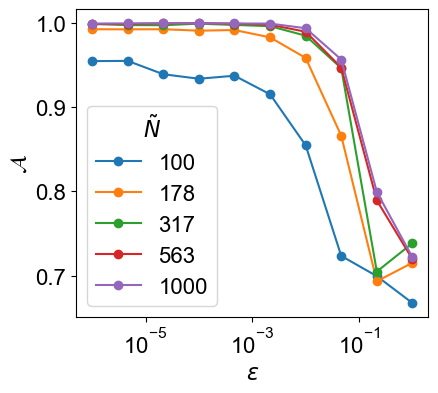

In [32]:
plt.figure(figsize=(10,4))

plt.subplot(121)
for i in range(len(num_repeats_list)):
    plt.plot(noise_list2**2,auc_list3[i,:],'o-')

plt.xscale('log')
plt.xlabel(r'$\epsilon$')
plt.ylabel(r'$\mathcal{A}$')
plt.legend(num_repeats_list,title=r'$\tilde N$')

In [31]:
t1 = {}
t1["noise_list"] = noise_list2
t1["auc_list"]   = auc_list2
np.save("data/kuramoto_network_noisy_auc_noise_withError",t1)

## Read Linear network data:

In [33]:
t_linear = np.load("data/linear_network_noisy_auc_noise3.npy",allow_pickle= True).item()

In [34]:
t_linear["noise_list"]

array([0.001     , 0.00215443, 0.00464159, 0.01      , 0.02154435,
       0.04641589, 0.1       , 0.21544347, 0.46415888, 1.        ])

In [35]:
t_linear_new = np.load("data/linear_network_noisy_auc_noise3_small_dt_small_T_withError.npy",allow_pickle= True).item()

In [36]:
t_KM = np.load("data/kuramoto_network_noisy_auc_noise_withError.npy",allow_pickle= True).item()

## Calculate the MP values of the basis functions (the natural frequency):

In [37]:
#Noise Parameters:
num_basis = num_subnw+1
A  = []

#for n in range(len(noise_list2)):

#    for n_reps in range(len(num_repeats_list)):

n = 4
n_reps = -1

d1  = utilities.design_matrix_KM(soln2[n,:int(T/deltaT)*num_repeats_list[n_reps],0:num_subnw])

for i in range(num_subnw):
    A.append(np.diag(alpha_opt3[n_reps,n,i]*np.ones(num_basis)) + beta_opt2[n_reps,n,i]*np.matmul(d1.T,d1))

W_mp          = np.zeros([num_basis,num_subnw])
predicted     = np.zeros([len(obs_noise2[n,:int(T/deltaT)*num_repeats_list[n_reps],0]),num_subnw])
predicted_var = np.zeros([len(obs_noise2[n,:int(T/deltaT)*num_repeats_list[n_reps],0]),num_subnw])

for i in range(num_subnw):
    W_mp[:,i]          = beta_opt2[n_reps,n,i]*np.matmul(np.linalg.inv(A[i]),np.matmul(d1.T,obs_noise2[n,:int(T/deltaT)*num_repeats_list[n_reps],i]))
    predicted[:,i]     = np.matmul(W_mp[:,i],d1.T)
    #for j in range(len(obs)):
    #    predicted_var[j,i] = np.matmul(basis(soln[j,0:3]).T,np.matmul(np.linalg.inv(A[i]),basis(soln[j,0:3]))) + 1./beta_opt[i]

NameError: name 'alpha_opt2' is not defined

Text(0, 0.5, '$\\Omega$')

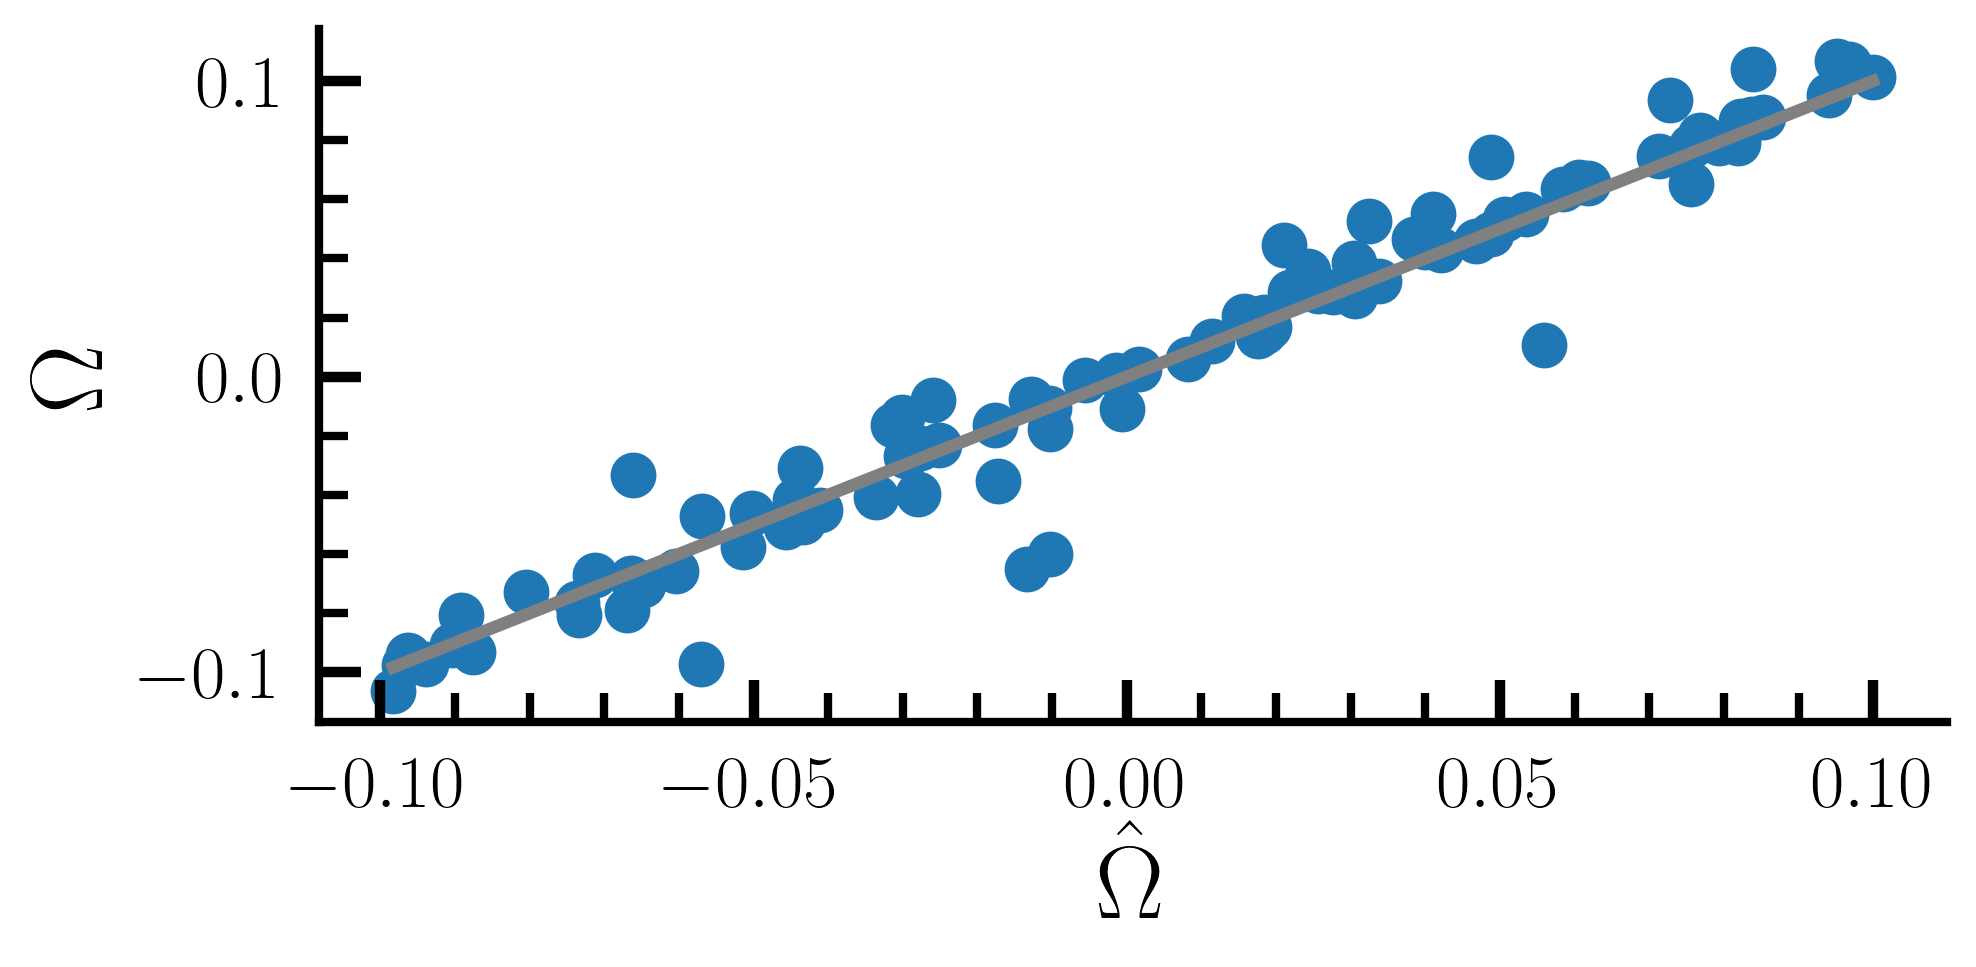

In [44]:
plt.scatter(Ω[:num_subnw],[W_mp[0,i] for i in range(num_subnw)])
plt.plot(np.linspace(min(Ω),max(Ω)),np.linspace(min(Ω),max(Ω)),color='gray')
plt.xlabel(r'$\hat \Omega$')
plt.ylabel(r'$\Omega$')

In [198]:
print('Noise level = ', noise_list2[n])
num_repeats_list[n_reps]

Noise level =  0.021544346900318832


1000

## Plot together: Linear + Kuramoto

In [ ]:
from matplotlib import colors
from config.plot_config import *
import matplotlib as mpl

/tmp/ipykernel_966500/3529648522.py:56: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax3.scatter(Ω[:num_subnw],[W_mp[0,i] for i in range(num_subnw)],marker='o',s=5,c=COLORS(4),alpha=alpha_m,label='_')


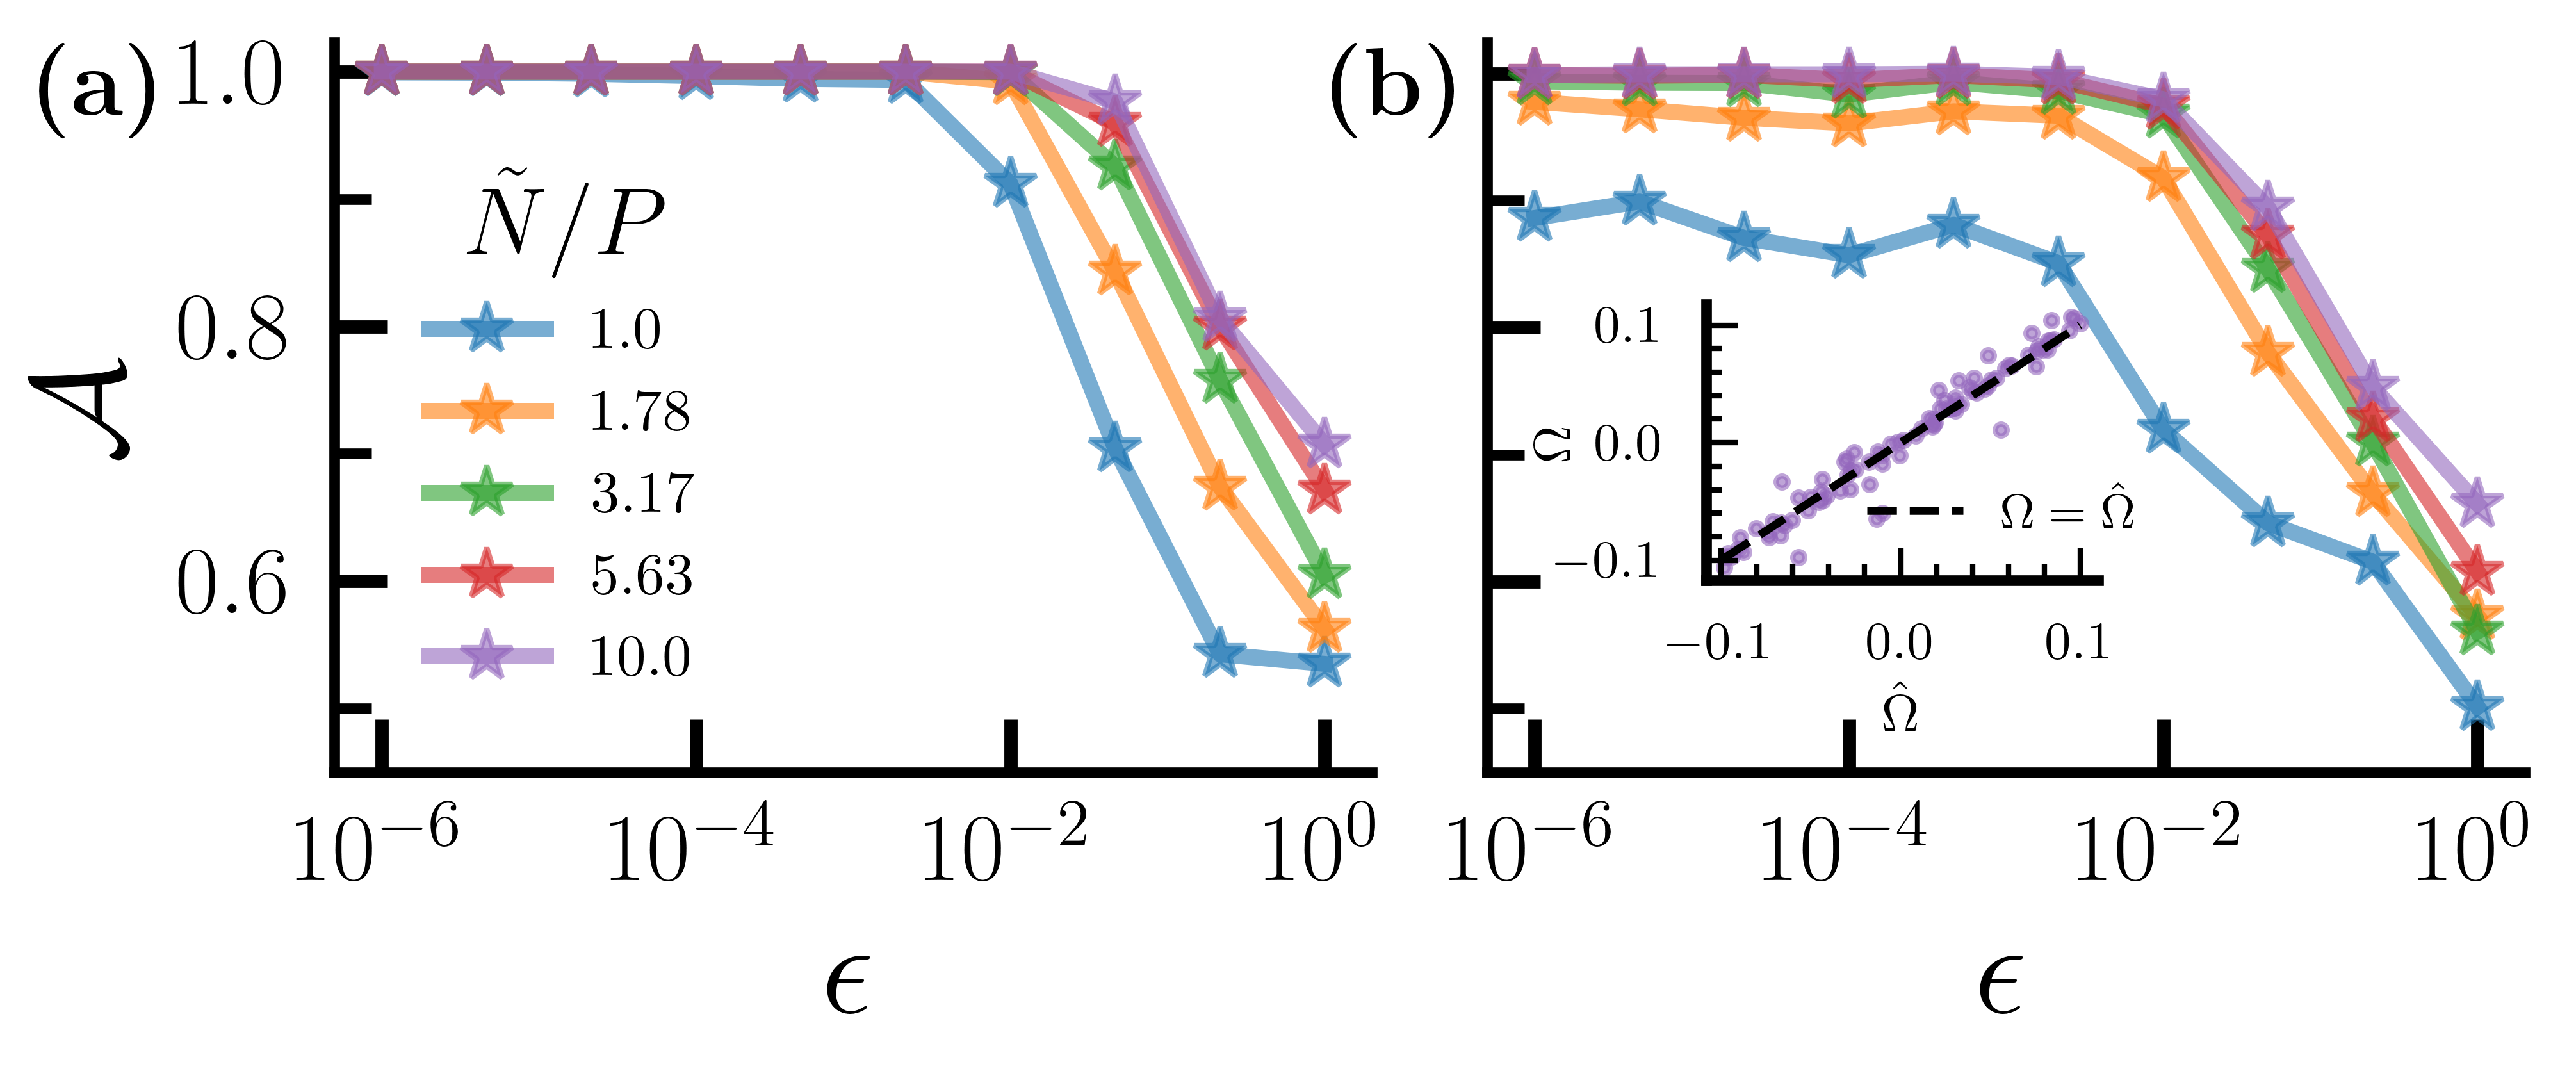

In [70]:
fig = plt.figure(figsize=(6., 2.), dpi=600)#(figsize=(7, 2.5))
dx_a, dy_a = .45, .95
x_pos = .55
y_pos = .05

alpha_m = .6

ax1 = fig.add_axes([.05, y_pos, dx_a, dy_a])
ax2 = fig.add_axes([x_pos, y_pos, dx_a, dy_a])

marker_list = ['*', 'o']
marker = '*'

for i in range(len(num_repeats_list)):
    ax1.plot(t_linear_new["noise_list"]**2,t_linear_new["auc_list"][i,:], marker=marker,alpha=alpha_m, color=COLORS(i))#,ls=(0,(1,1)))

ax1.set_xscale('log')
#ax1.legend(num_repeats_list,bbox_to_anchor=(1.3, 1.4), bbox_transform=ax2.transAxes, loc=1, frameon=False, ncols=10)#, fontsize=16)

ax1.set_ylim(ymin=0.45)
ax1.set_ylabel(s_auc)
ax1.set_xlabel(r'$\epsilon$')
#ax1.legend(num_repeats_list,frameon=True, framealpha=.2,fontsize=10,title=s_N_exp)

ax1.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(.1))
#ax1.xaxis.set_minor_locator(mpl.ticker.NullLocator())
#ax1.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(.1))
ax1.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax1.xaxis.set_major_locator(mpl.ticker.LogLocator(base=10, subs=(1.0,),numticks=5))

### Second Plot ###

marker = '*'

for i in range(len(num_repeats_list)):
    ax2.plot(t_KM["noise_list"]**2,t_KM["auc_list"][i,:], marker=marker,alpha=alpha_m, color=COLORS(i))#,ls=(0,(1,1)))

ax2.set_xscale('log')
#ax2.legend(num_repeats_list,bbox_to_anchor=(1.3, 1.4), bbox_transform=ax2.transAxes, loc=1, frameon=False, ncols=10,title=s_N_exp)#, fontsize=16)

ax2.set_ylim(ymin=0.45)
#ax2.set_ylabel(s_auc)
ax2.set_xlabel(r'$\epsilon$')
ax1.legend(num_repeats_list/100,frameon=False, framealpha=.2,fontsize=11,title=s_N_exp+r"$/P$",bbox_to_anchor=(.4, 0.9),loc=1,)

ax2.yaxis.set_tick_params(label1On=False)
ax2.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(.1))
#ax2.xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10, subs=(0.1,)))
#ax2.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax2.xaxis.set_major_locator(mpl.ticker.LogLocator(base=10, subs=(1.0,),numticks=5))

ax1.text(-0.285, .9, r'$\textbf{(a)}$', transform=ax1.transAxes, )
ax2.text(-0.15, .9, r'$\textbf{(b)}$', transform=ax2.transAxes, )

ax3 = fig.add_axes([x_pos+0.095, y_pos+0.25, dx_a/(2.65), dy_a/(2.65)])
ax3.scatter(Ω[:num_subnw],[W_mp[0,i] for i in range(num_subnw)],marker='o',s=5,c=COLORS(4),alpha=alpha_m,label='_')
ax3.plot(np.linspace(min(Ω),max(Ω)),np.linspace(min(Ω),max(Ω)),color='black',linewidth=1.5,linestyle='dashed',label=r'$\Omega = \hat \Omega$')
ax3.set_xlabel(r'$\hat \Omega$',fontsize=10)
ax3.set_ylabel(r'$\Omega$',fontsize=10,labelpad=-5)
ax3.patch.set_alpha(0)

ax3.xaxis.set_tick_params(which='major', size=6, width=1, direction='in', top=False)
ax3.xaxis.set_tick_params(which='minor', size=3, width=1, direction='in' , top=False)
ax3.yaxis.set_tick_params(which='major', size=6, width=1, direction='in', right=False)
ax3.yaxis.set_tick_params(which='minor', size=3, width=1, direction='in' , right=False)

#ax3.xaxis.set_ticklabels()

ax3.legend(fontsize=9,bbox_to_anchor=(0.3, 0., 0.5, 0.5))
ax3.tick_params(axis='x', labelsize=10)
ax3.tick_params(axis='y', labelsize=10)

ax1.set_xlim(xmax=2,xmin=5e-7)
ax1.set_xticks([1e-6, 1e-4, 1e-2,1])

ax2.set_xlim(xmax=2,xmin=5e-7)
ax2.set_xticks([1e-6, 1e-4, 1e-2,1])
